<a href="https://colab.research.google.com/github/khushimitr/PubMedAbstracts/blob/main/PubMed_200K_RCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Now we have performed many experiments on 20K RCT dataset and trained it on 10% of that data. 
We found that **model_1_custom_token_embed_conv1d** and **model_5_tribrid_pos_char_token_embed** 
were the best performing models. So we will run these 2 experiments for the whole data.
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-763cdd75-2394-ad5c-959f-6c15f8d23e7f)


## Get the Data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [5]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [7]:
!wget https://raw.githubusercontent.com/khushimitr/HandGestureRecognition/main/helperfunctions.py

from helperfunctions import calculate_results,unzip_data,create_tensorboard_callback, plot_loss_curves

--2022-01-19 12:01:43--  https://raw.githubusercontent.com/khushimitr/HandGestureRecognition/main/helperfunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9735 (9.5K) [text/plain]
Saving to: ‘helperfunctions.py’

helperfunctions.py  100%[===================>]   9.51K  --.-KB/s    in 0s      

2022-01-19 12:01:43 (98.1 MB/s) - ‘helperfunctions.py’ saved [9735/9735]



In [8]:
unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

In [9]:
!cp "/content/train.txt" "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [10]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Becoming One with data

In [11]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads filename(.txt) and returns the lines of text as a list.
    """
    with open(filename,'r') as f:
        return f.readlines()

In [12]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [13]:
len(train_lines)

2593169

## Preprocessing data

In [14]:
def preprocess_text(filename):
    """
    Returns a list of dictionary of abstract line data
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_lines_split = abstract_lines.splitlines()

            for abstract_ln_no, abstract_ln in enumerate(abstract_lines_split):
                data = {}
                target_text_split = abstract_ln.split("\t")
                data["target"] = target_text_split[0]
                data["text"] = target_text_split[1].lower()
                data["line_number"] = abstract_ln_no
                data["total_lines"] = len(abstract_lines_split) - 1
                abstract_samples.append(data)
        else:
            abstract_lines += line

    return abstract_samples

In [15]:
val_samples = preprocess_text(data_dir + "dev.txt")
train_samples = preprocess_text(data_dir + "train.txt")
test_samples = preprocess_text(data_dir + "test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

2211861 28932 29493


In [16]:
train_samples[:10]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'total_lines': 10},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'total_lines': 10},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'total_lines': 10},
 {'line_number': 3,
  'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'total_lines': 10},
 {'line_number': 4,
  'tar

In [17]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [18]:
# distrubution of labels in training Data
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

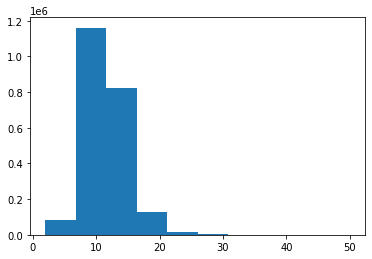

In [19]:
# Let's Check the length of different lines
train_df.total_lines.hist(grid = False)

### Get list of Sentences

In [20]:
train_sen = train_df["text"].tolist()
val_sen = val_df["text"].tolist()
test_sen = test_df["text"].tolist()
print(len(train_sen),len(val_sen),len(test_sen))

2211861 28932 29493


In [21]:
train_sen[:5]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .']

### Make Labels (One Hot Encoded and Numerical Encoded)

In [22]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_oh = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_oh = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_oh = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_oh

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [23]:
# Numeric Encoded Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [24]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments

### Model 0: MultiNomial Naive Bayes TF-IDF (Baseline)

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sen, y = train_labels_encoded);

In [86]:
## Gives Accuracy on Validation Dataset
model_0.score(X = val_sen,
                 y = val_labels_encoded)

0.7497580533665146

In [87]:
## Make Predictions
baseline_preds = model_0.predict(val_sen)
baseline_preds

array([0, 4, 4, ..., 4, 4, 1])

In [88]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 74.97580533665146,
 'f1': 0.7389570175489825,
 'precision': 0.7431966265737352,
 'recall': 0.7497580533665146}

### Text Vectorization Layer

In [89]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [90]:
# How long is each sentence?
sen_lens = [len(sentence.split()) for sentence in train_sen]
avg_sen_len = np.mean(sen_lens)
avg_sen_len

26.229355280462922

(array([6.656900e+05, 1.064939e+06, 3.491070e+05, 9.095700e+04,
        2.651300e+04, 8.980000e+03, 3.125000e+03, 1.374000e+03,
        5.800000e+02, 2.770000e+02, 1.350000e+02, 7.100000e+01,
        5.200000e+01, 2.400000e+01, 1.900000e+01, 6.000000e+00,
        4.000000e+00, 5.000000e+00, 1.000000e+00, 2.000000e+00]),
 array([  1.  ,  17.85,  34.7 ,  51.55,  68.4 ,  85.25, 102.1 , 118.95,
        135.8 , 152.65, 169.5 , 186.35, 203.2 , 220.05, 236.9 , 253.75,
        270.6 , 287.45, 304.3 , 321.15, 338.  ]),
 <a list of 20 Patch objects>)

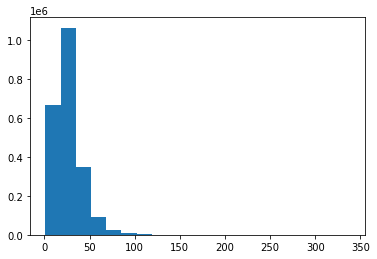

In [91]:
# Distribution of sentences length
import matplotlib.pyplot as plt
plt.hist(sen_lens,bins = 20)

In [92]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sen_lens,95))
output_seq_len

54

In [93]:
max(sen_lens)

338

```
# How many words are in our vocab? (taken from table 3.2 in : https://arxiv.org/pdf/1710.06071.pdf)

```

In [94]:
max_tokens = 331000

In [95]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [96]:
train_sen_dataset = tf.data.Dataset.from_tensor_slices(train_sen)
train_sen_dataset = train_sen_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_sen_dataset

<PrefetchDataset shapes: (None,), types: tf.string>

In [97]:
text_vectorizer.adapt(train_sen_dataset)

In [98]:
import random
target_sen = random.choice(train_sen)
print(f"Text:\n{target_sen}")
print(f"\nLength of text : {len(target_sen.split())}")
print(f"\nVectorized text : {text_vectorizer([target_sen])}")

Text:
to compare the effectiveness of scaling and root planing ( srp ) with the use of hand instruments to that of non-surgical treatment with the use of an ultrasonic device , using clinical and microbiological criteria .

Length of text : 37

Vectorized text : [[   6  207    2  298    3 3441    4 1344 5242 3521    7    2   84    3
  1110 2495    6   26    3 4753   17    7    2   84    3   30 4101  751
    66   48    4 4735  400    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [99]:
# How many words in our training vocab
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 247961
Most common words in vocab: ['', '[UNK]', 'the', 'of', 'and']
Least common words in vocab: ['aaae', 'aaacp', 'aaabbb', 'aaaanalog', 'aaaa']


In [100]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 331000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 54,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create Custom Embedding layer

In [101]:
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

In [102]:
print(f"Sentence before vectorization:\n{target_sen}")
vectorized_sen = text_vectorizer([target_sen])
print(f"Sentence after vectorization(before embedding):\n{vectorized_sen}")
embedded_sen = token_embed(vectorized_sen)
print(f"Sentence after embedding):\n{embedded_sen}\n")
print(f"Embedded Sentence shape : {embedded_sen.shape}")

Sentence before vectorization:
to compare the effectiveness of scaling and root planing ( srp ) with the use of hand instruments to that of non-surgical treatment with the use of an ultrasonic device , using clinical and microbiological criteria .
Sentence after vectorization(before embedding):
[[   6  207    2  298    3 3441    4 1344 5242 3521    7    2   84    3
  1110 2495    6   26    3 4753   17    7    2   84    3   30 4101  751
    66   48    4 4735  400    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding):
[[[-0.01945722  0.04908407  0.01956571 ...  0.01804072  0.01941052
   -0.01828914]
  [-0.03796673 -0.01744317 -0.01338295 ... -0.02801871 -0.03508598
    0.01281573]
  [-0.00077726 -0.01697133 -0.01830183 ...  0.02440922  0.02508927
    0.04589385]
  ...
  [-0.00569184 -0.04236834 -0.02408779 ...  0.01693222 -0.02763097
    0.04255207]
  [-0.00569184 -0.04236834 -0.02408779 ...  0.01693222 -0.0

### Creating Datasets For our Model 1

In [103]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sen,train_labels_oh))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sen,val_labels_oh))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sen,test_labels_oh))
 
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [104]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1 : Conv1D with custom Token Embeddings

In [105]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings= token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [106]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 54)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 54, 128)          31739008  
                                                                 
 conv1d (Conv1D)             (None, 54, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0   

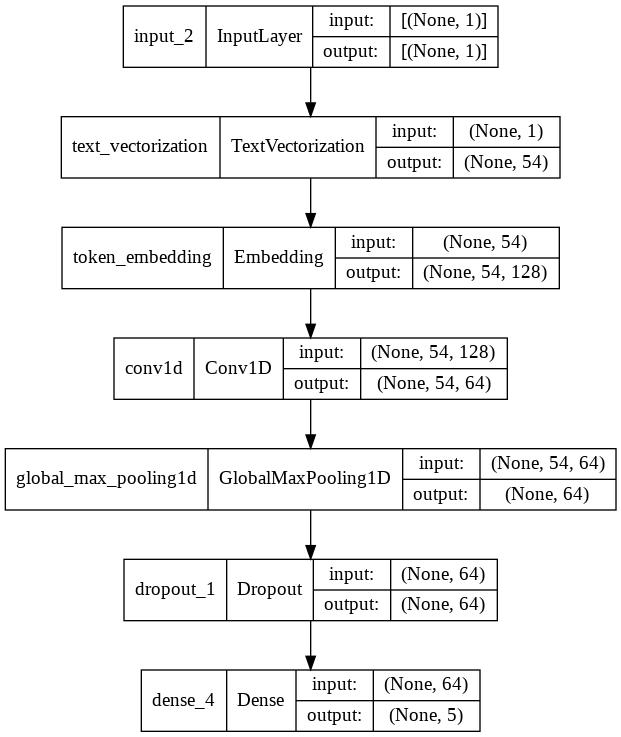

In [107]:
tf.keras.utils.plot_model(model_1,show_shapes=True)

In [108]:
run_dir = "/content/drive/MyDrive/machine_learning/Checkpoints/Model1/"
checkpoint_path = os.path.join(run_dir,'model-{epoch:02d}-{val_loss:02f}.ckpt')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_accuracy")

In [ ]:
# rm -r "/content/drive/MyDrive/machine_learning/Checkpoints/Model1/"

In [ ]:
# os.mkdir("/content/drive/MyDrive/machine_learning/Checkpoints/Model1")

In [109]:
model_1.save_weights(checkpoint_path.format(epoch=0,val_loss=0.00))

In [110]:
history_model_1 = model_1.fit(
    train_dataset,
    epochs = 4,
    steps_per_epoch = int(0.2 * len(train_dataset)),
    validation_data = valid_dataset,
    validation_steps = int(0.1*len(valid_dataset)),
    callbacks = [checkpoint_callback,create_tensorboard_callback("PubMedAbstracts","model_1_Conv1D")]
)

Saving TensorBoard log files to: PubMedAbstracts/model_1_Conv1D/20220119-124644
Epoch 1/4
13824/13824 [==============================] - 294s 21ms/step - loss: 0.5877 - accuracy: 0.7913 - val_loss: 0.4714 - val_accuracy: 0.8271
Epoch 2/4
13824/13824 [==============================] - 287s 21ms/step - loss: 0.5299 - accuracy: 0.8126 - val_loss: 0.4562 - val_accuracy: 0.8375
Epoch 3/4
13824/13824 [==============================] - 288s 21ms/step - loss: 0.5188 - accuracy: 0.8172 - val_loss: 0.4485 - val_accuracy: 0.8368
Epoch 4/4
13824/13824 [==============================] - 287s 21ms/step - loss: 0.5094 - accuracy: 0.8189 - val_loss: 0.4348 - val_accuracy: 0.8410


In [111]:
checkpoint_dir = os.path.dirname(checkpoint_path)

In [112]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/content/drive/MyDrive/machine_learning/Checkpoints/Model1/model-04-0.434800.ckpt'

In [ ]:
# model_1.load_weights(latest)

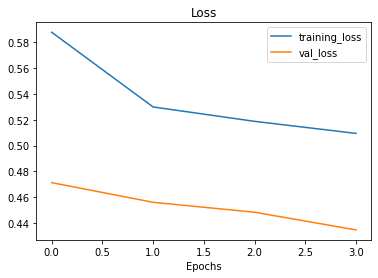

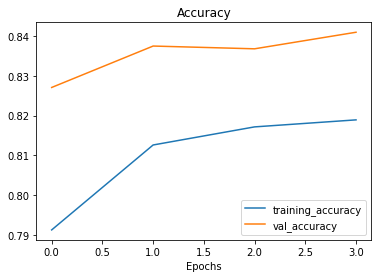

In [113]:
plot_loss_curves(history_model_1)

In [114]:
model_1.evaluate(valid_dataset)

905/905 [==============================] - 3s 3ms/step - loss: 0.4352 - accuracy: 0.8431


[0.43523359298706055, 0.8431494832038879]

In [115]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape

(28932, 5)

In [116]:
model_1_preds = tf.argmax(model_1_pred_probs,axis = 1)
model_1_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 4, 1])>

In [117]:
model_1_results = calculate_results(y_pred=model_1_preds,
                                    y_true = val_labels_encoded)
model_1_results

{'accuracy': 84.31494538918844,
 'f1': 0.840380475217552,
 'precision': 0.8402848025550695,
 'recall': 0.8431494538918844}

In [ ]:
# model_1.save("/content/drive/MyDrive/machine_learning/Conv1DPubMed")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/machine_learning/Conv1DPubMed/assets


In [ ]:
# import tensorflow_hub as hub
# import tensorflow as tf
# from tensorflow.keras.layers import TextVectorization

# model_path = "/content/drive/MyDrive/machine_learning/Conv1DPubMed"
# loaded_model = tf.keras.models.load_model(model_path,custom_objects={"TextVectorization": TextVectorization,"KerasLayer": hub.KerasLayer})

### PreTrained Token Embeddings

In [25]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable = False,
    name = "USE"
)

In [28]:
import random
random_train_sen = random.choice(train_sen)
print(f"Random sentence:\n {random_train_sen}")
use_embedded_sen = tf_hub_embedding_layer([random_train_sen])
print(f"Sentence after embedding :\n{use_embedded_sen[0][:20]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sen[0])}")

Random sentence:
 in group @ they were in left lateral decubitus position .
Sentence after embedding :
[-0.02546365  0.06072241 -0.0263826   0.02011101 -0.00612667  0.05610172
 -0.00847443  0.0046117  -0.09279092  0.0559184  -0.03396956  0.03375643
  0.01706357 -0.0014852   0.05297465  0.03439082  0.02828443 -0.03714703
 -0.00929242  0.00421594]

Length of sentence embedding: 512


### Creating Character Vectorization Layer

In [29]:
def split_to_chars(text):
    return " ".join(list(text))

In [30]:
train_chars = [split_to_chars(sentence) for sentence in train_sen]
val_chars = [split_to_chars(sentence) for sentence in val_sen]
test_chars = [split_to_chars(sentence) for sentence in test_sen]

test_chars[:5]

['m a n y   p a t h o g e n i c   p r o c e s s e s   a n d   d i s e a s e s   a r e   t h e   r e s u l t   o f   a n   e r r o n e o u s   a c t i v a t i o n   o f   t h e   c o m p l e m e n t   c a s c a d e   a n d   a   n u m b e r   o f   i n h i b i t o r s   o f   c o m p l e m e n t   h a v e   t h u s   b e e n   e x a m i n e d   f o r   a n t i - i n f l a m m a t o r y   a c t i o n s   .',
 'i t   w a s   r e c e n t l y   d e m o n s t r a t e d   t h a t   s u p r a p h y s i o l o g i c a l   c o n c e n t r a t i o n s   o f   t h e   e n d o g e n o u s   c o m p l e m e n t   i n h i b i t o r   m a p @   (   a l s o   d e n o t e d   m a p @   )   p r o t e c t   a g a i n s t   m y o c a r d i a l   r e p e r f u s i o n   i n j u r y   .',
 'i n   t h e   p r e s e n t   s t u d y   ,   w e   e x a m i n e d   t h e   a s s o c i a t i o n   b e t w e e n   o u t c o m e   a f t e r   a c u t e   m y o c a r d i a l   i n f a r c t i o n   (   m i   )   a n d 

In [33]:
# Avg character length
import numpy as np

char_lens = [len(sentence) for sentence in train_sen]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

(array([2.030236e+06, 1.779350e+05, 3.470000e+03, 1.980000e+02,
        2.000000e+01, 1.000000e+00, 1.000000e+00]),
 array([1.00000000e+00, 2.54428571e+02, 5.07857143e+02, 7.61285714e+02,
        1.01471429e+03, 1.26814286e+03, 1.52157143e+03, 1.77500000e+03]),
 <a list of 7 Patch objects>)

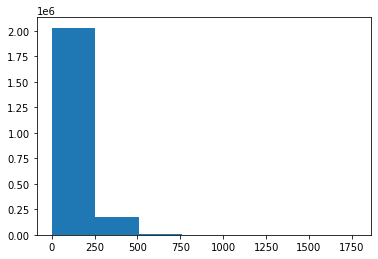

In [35]:
# Check distribution

import matplotlib.pyplot as plt
plt.hist(char_lens,bins = 7)

In [36]:
# What character length covers 95% of the lengths?
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

284

In [37]:
# Get all keyboard characters
import string
alphabet=  string.ascii_lowercase + string.digits+ string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
# Char level token vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

num_char_tokens = len(alphabet) + 2 # for space and UNK(Unkown)
char_vectorizer = TextVectorization(
    max_tokens = num_char_tokens,
    output_sequence_length = output_seq_char_len,
    name = "char_vectorizer"
)

In [39]:
train_char_dataset = tf.data.Dataset.from_tensor_slices(train_chars)
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset shapes: (None,), types: tf.string>

In [42]:
char_vectorizer.adapt(train_char_dataset)

In [43]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab : {len(char_vocab)}")
print(f"5 most common characters : {char_vocab[:5]}")
print(f"5 least common characters : {char_vocab[-5:]}")

Number of different characters in character vocab : 28
5 most common characters : ['', '[UNK]', 'e', 't', 'a']
5 least common characters : ['k', 'x', 'z', 'q', 'j']


In [44]:
random_train_chars = random.choice(train_chars)
print(f"Charified text : \n{random_train_chars}")
print(f"\nLength of random_train_chars : {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars : \n{vectorized_chars}")
print(f"length of vectorized chars : {len(vectorized_chars[0])}")

Charified text : 
u n l i k e   p r e v i o u s   w o r k   ,   w e   f o u n d   n o   e v i d e n c e   o f   m e m o r y   i m p a i r m e n t   f o r   m a t e r i a l   p r e s e n t e d   b e f o r e   o r   a f t e r   i n d i v i d u a l l y   t a i l o r e d   ,   `   b r e a k t h r o u g h   '   d o s e s   o f   i m m e d i a t e - r e l e a s e   o p i o i d   .

Length of random_train_chars : 153

Vectorized chars : 
[[16  6 11  5 23  2 14  8  2 21  5  7 16  9 20  7  8 23 20  2 17  7 16  6
  10  6  7  2 21  5 10  2  6 12  2  7 17 15  2 15  7  8 19  5 15 14  4  5
   8 15  2  6  3 17  7  8 15  4  3  2  8  5  4 11 14  8  2  9  2  6  3  2
  10 22  2 17  7  8  2  7  8  4 17  3  2  8  5  6 10  5 21  5 10 16  4 11
  11 19  3  4  5 11  7  8  2 10 22  8  2  4 23  3 13  8  7 16 18 13 10  7
   9  2  9  7 17  5 15 15  2 10  5  4  3  2  8  2 11  2  4  9  2  7 14  5
   7  5 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Create Custom Character Embedding Layer

In [45]:
char_embed = layers.Embedding(
    input_dim=len(char_vocab),
    output_dim = 25, # From paper
    mask_zero = False,
    name = "char_embed"
)

In [46]:
print(f"Charified text : \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embediing) : \n{char_embed_example}\n")
print(f"Character Embediing shape : {char_embed_example.shape}")

Charified text : 
u n l i k e   p r e v i o u s   w o r k   ,   w e   f o u n d   n o   e v i d e n c e   o f   m e m o r y   i m p a i r m e n t   f o r   m a t e r i a l   p r e s e n t e d   b e f o r e   o r   a f t e r   i n d i v i d u a l l y   t a i l o r e d   ,   `   b r e a k t h r o u g h   '   d o s e s   o f   i m m e d i a t e - r e l e a s e   o p i o i d   .

Embedded chars (after vectorization and embediing) : 
[[[ 0.00154991 -0.02039826 -0.0273296  ... -0.03715732  0.00453473
   -0.00787549]
  [ 0.04550732  0.02323735  0.04863305 ... -0.03782171  0.03967703
    0.04183051]
  [ 0.04049592 -0.04122614  0.0309688  ... -0.04619223  0.03122339
   -0.00283917]
  ...
  [-0.04640565 -0.03087953  0.00175562 ... -0.04510758  0.00865268
    0.01952796]
  [-0.04640565 -0.03087953  0.00175562 ... -0.04510758  0.00865268
    0.01952796]
  [-0.04640565 -0.03087953  0.00175562 ... -0.04510758  0.00865268
    0.01952796]]]

Character Embediing shape : (1, 284, 25)


### Create Positional Embeddings

In [47]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
38         6
39         6
40         6
41         5
42         5
43         5
44         4
45         4
46         3
48         2
49         2
47         2
50         1
Name: line_number, dtype: int64

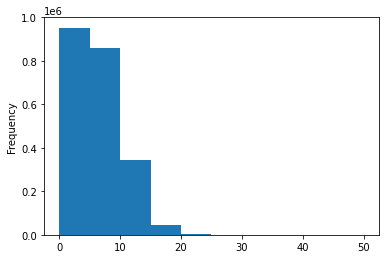

In [48]:
# Check the distribution of column
train_df.line_number.plot.hist()

In [49]:
train_line_no_oh = tf.one_hot(train_df["line_number"].to_numpy(),depth= 15)
val_line_no_oh = tf.one_hot(val_df["line_number"].to_numpy(),depth= 15)
test_line_no_oh = tf.one_hot(test_df["line_number"].to_numpy(),depth= 15)
train_line_no_oh[:10],train_line_no_oh.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([2211861, 15]))

In [50]:
# How many different total line values are there?
train_df["total_lines"].value_counts()

10    304733
11    303648
12    266682
9     259640
13    212296
8     183168
14    156015
15    111712
7     110240
16     74987
6      53088
17     48672
18     31502
19     22100
5      21174
20     13797
21      9988
4       6385
22      5750
23      3984
24      2750
25      1924
26      1485
27      1148
3       1148
28       870
29       720
33       442
31       416
30       279
32       264
35       180
34       140
37       114
36       111
50        51
49        50
46        47
45        46
43        44
40        41
2         30
Name: total_lines, dtype: int64

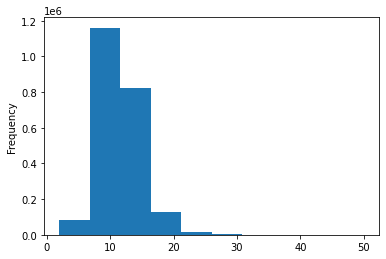

In [51]:
# Check the distribution
train_df.total_lines.plot.hist()

In [52]:
np.percentile(train_df.total_lines,95), np.percentile(train_df.total_lines,98)

(17.0, 20.0)

In [53]:
train_total_lines_no_oh = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_no_oh = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_no_oh = tf.one_hot(test_df["total_lines"].to_numpy(),depth= 20)
train_total_lines_no_oh[:10],train_total_lines_no_oh.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0

### Creating datasets for model 2

In [54]:
final_train_data = tf.data.Dataset.from_tensor_slices((train_line_no_oh,train_total_lines_no_oh,train_sen,train_chars))
final_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
final_train_dataset = tf.data.Dataset.zip((final_train_data,final_train_labels))

final_train_dataset = final_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
final_train_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [55]:
final_val_data = tf.data.Dataset.from_tensor_slices((val_line_no_oh,val_total_lines_no_oh,val_sen,val_chars))
final_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
final_val_dataset = tf.data.Dataset.zip((final_val_data,final_val_labels))

final_val_dataset = final_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
final_val_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [56]:
final_test_data = tf.data.Dataset.from_tensor_slices((test_line_no_oh,test_total_lines_no_oh,test_sen,test_chars))
final_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
final_test_dataset = tf.data.Dataset.zip((final_test_data,final_test_labels))

final_test_dataset = final_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
final_test_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

### Model 2 : Transfer learning with pretrained token embediings + character embeddings + positional embediings

In [57]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype = tf.string,name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(256,activation ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

In [58]:
# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype = tf.string,name= "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

In [59]:
# 3. Line Number Model
line_no_inputs = layers.Input(shape=(15,),dtype = tf.float32,name="line_no_inputs")
x = layers.Dense(32,activation="relu")(line_no_inputs)
line_no_model = tf.keras.Model(inputs = line_no_inputs,
                               outputs = x)

In [60]:
# 4. Total Line Number Model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_inputs")
y = layers.Dense(32,activation="relu")(total_lines_inputs)

total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                      outputs = y)

In [61]:
# 5. Combine 1 and 2 into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

In [62]:
# 6. 
z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [63]:
# 7. Combine positional embediing with 5
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_no_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

In [64]:
# 8. Create output layer
output_layer = layers.Dense(num_classes,activation="softmax",name = "output_layer")(tribrid_embeddings)

In [65]:
# 9. Put together model with all kinds of inputs
model_2 = tf.keras.Model(
    inputs=[
            line_no_model.input,
            total_lines_model.input,
            token_model.input,
            char_model.input
    ],
    outputs=output_layer,
    name = "tribrid_embedding_model"
)

In [66]:
model_2.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 284)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inp

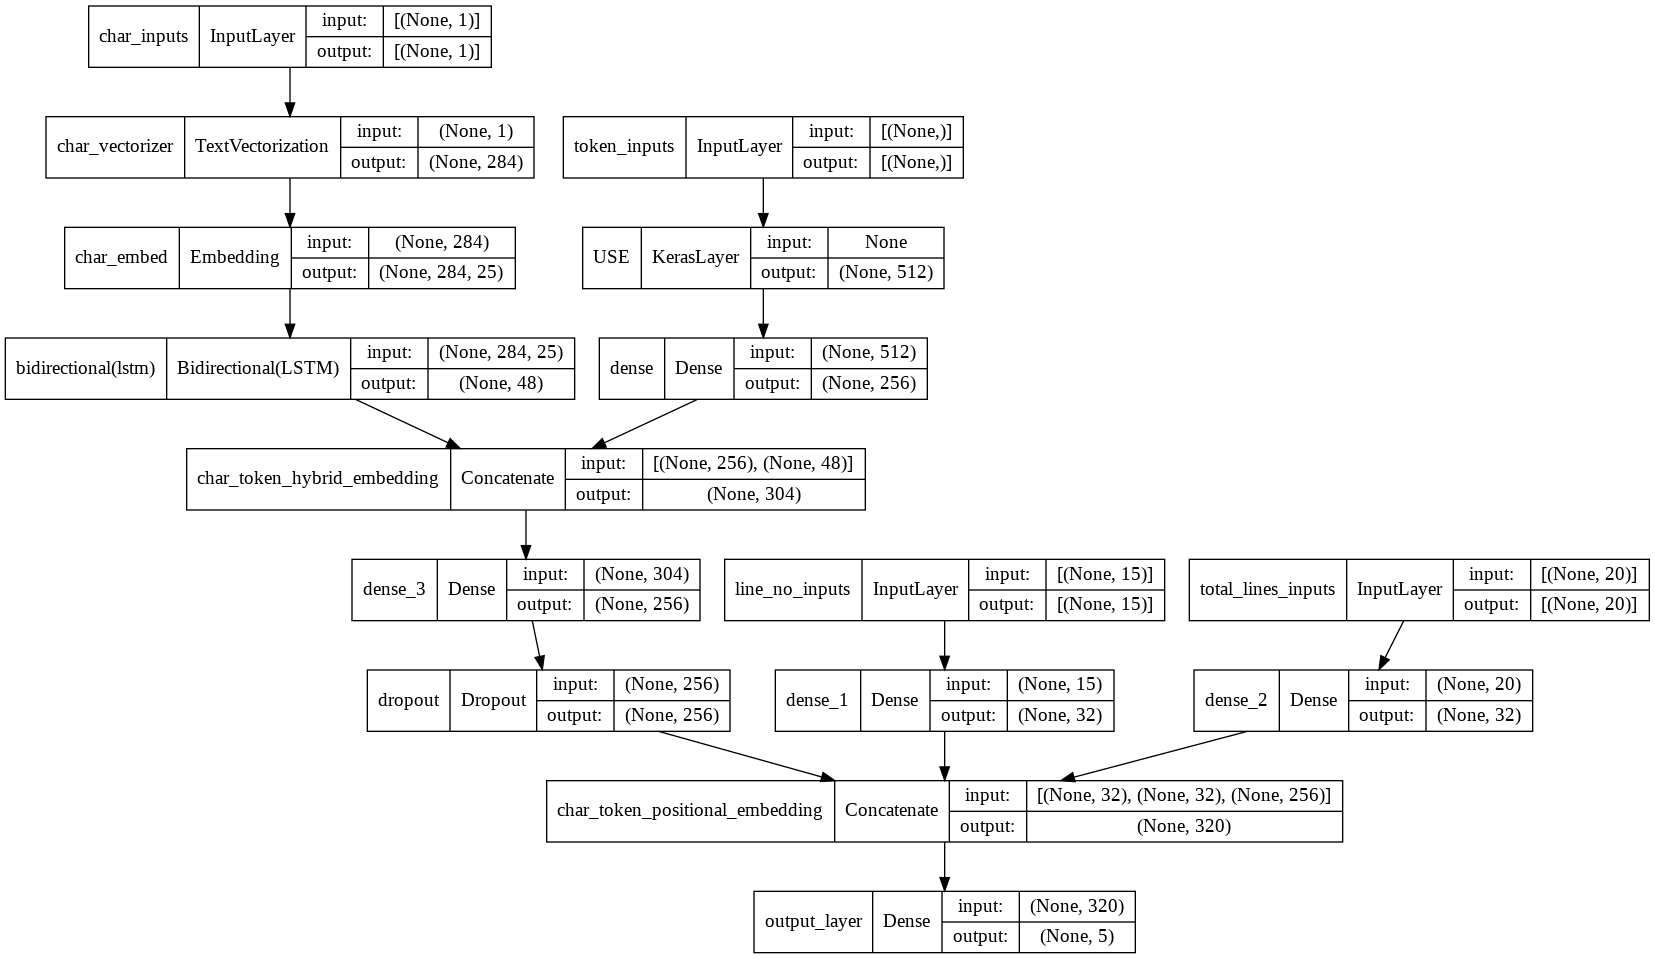

In [67]:
tf.keras.utils.plot_model(model_2,show_shapes = True)

In [68]:
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
run_dir = "/content/drive/MyDrive/machine_learning/Checkpoints/Model2/"
checkpoint_path = os.path.join(run_dir,'model-{epoch:02d}-{val_loss:02f}.ckpt')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_accuracy")

In [70]:
model_2.save_weights(checkpoint_path.format(epoch=0,val_loss=0.00))

In [75]:
len(train_sen)

2211861

In [78]:
0.2 * len(final_train_dataset) * 4

55296.8

In [77]:
history_model_2 = model_2.fit(
    final_train_dataset,
    epochs = 4,
    steps_per_epoch = int(0.2 * len(final_train_dataset)),
    # steps_per_epoch = len(final_train_dataset),
    validation_data = final_val_dataset,
    validation_steps = int(0.2 * len(final_val_dataset)),
    callbacks = [checkpoint_callback,create_tensorboard_callback("PubMedAbstracts","model_2_Tribrid")]
)

Saving TensorBoard log files to: PubMedAbstracts/model_2_Tribrid/20220119-121324
Epoch 1/4
13824/13824 [==============================] - 421s 30ms/step - loss: 0.9234 - accuracy: 0.8411 - val_loss: 0.8898 - val_accuracy: 0.8640
Epoch 2/4
13824/13824 [==============================] - 412s 30ms/step - loss: 0.8988 - accuracy: 0.8581 - val_loss: 0.8781 - val_accuracy: 0.8724
Epoch 3/4
13824/13824 [==============================] - 416s 30ms/step - loss: 0.8926 - accuracy: 0.8633 - val_loss: 0.8768 - val_accuracy: 0.8707
Epoch 4/4
13824/13824 [==============================] - 411s 30ms/step - loss: 0.8889 - accuracy: 0.8652 - val_loss: 0.8732 - val_accuracy: 0.8743


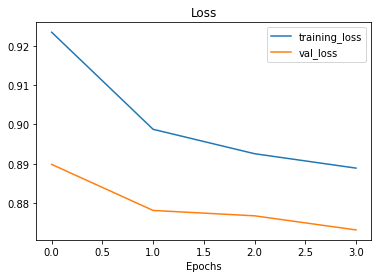

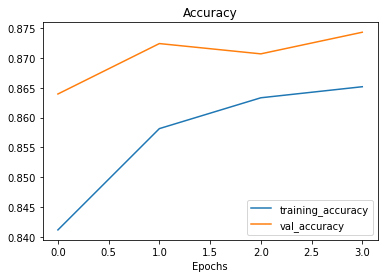

In [80]:
plot_loss_curves(history_model_2)   

In [81]:
model_2.evaluate(final_val_dataset)

905/905 [==============================] - 18s 20ms/step - loss: 0.8765 - accuracy: 0.8691


[0.876541256904602, 0.8691414594650269]

In [82]:
model_2_pred_probs = model_2.predict(final_val_dataset,verbose = 1)
model_2_pred_probs

905/905 [==============================] - 18s 19ms/step


array([[0.513867  , 0.0696909 , 0.03511568, 0.29096985, 0.09035655],
       [0.11624672, 0.03377767, 0.65773565, 0.14390707, 0.04833297],
       [0.18269679, 0.05339056, 0.21483232, 0.13808084, 0.41099957],
       ...,
       [0.03872681, 0.2880351 , 0.09225253, 0.0475422 , 0.53344333],
       [0.02887801, 0.24601446, 0.07285091, 0.04352657, 0.60873   ],
       [0.0492874 , 0.8251336 , 0.02723712, 0.03436274, 0.06397911]],
      dtype=float32)

In [83]:
model_2_preds = tf.argmax(model_2_pred_probs,axis = 1)
model_2_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 4, 1])>

In [84]:
model_2_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_2_preds)
model_2_results

{'accuracy': 86.91414350891746,
 'f1': 0.8675538469159115,
 'precision': 0.8688197128609749,
 'recall': 0.8691414350891746}

## Compare Model Results

In [118]:
model_results = pd.DataFrame(
    {
        "model_0_baseline": baseline_results,
        "model_1_custom_token_embed_conv1d": model_1_results,
        "model_2_tribrid_pos_char_token_embed": model_2_results
    }
)

model_results = model_results.transpose()
model_results

,accuracy,precision,recall,f1
model_0_baseline,74.975805,0.743197,0.749758,0.738957
model_1_custom_token_embed_conv1d,84.314945,0.840285,0.843149,0.840380
model_2_tribrid_pos_char_token_embed,86.914144,0.868820,0.869141,0.867554


In [119]:
model_results["accuracy"] = model_results["accuracy"]/100

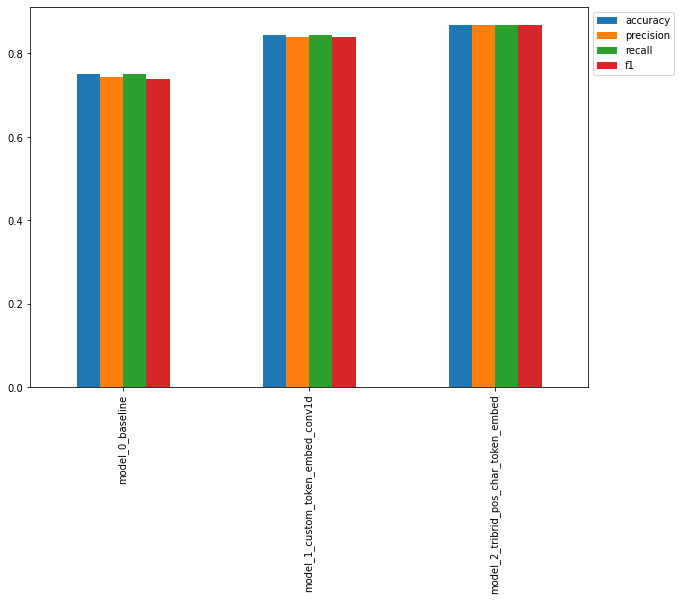

In [120]:
model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

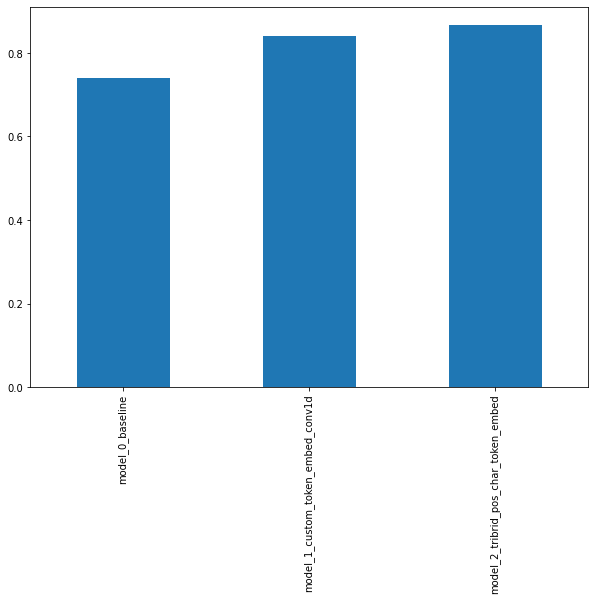

In [121]:
model_results.sort_values("f1",ascending = True)["f1"].plot(kind = "bar", figsize = (10,7))

## save and load model

In [122]:
model_2.save("/content/drive/MyDrive/machine_learning/pubmed_200k_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/machine_learning/pubmed_200k_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/machine_learning/pubmed_200k_model/assets


In [123]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [124]:
model_path = "/content/drive/MyDrive/machine_learning/pubmed_200k_model"
loaded_model = tf.keras.models.load_model(model_path,custom_objects={"TextVectorization": TextVectorization,"KerasLayer": hub.KerasLayer})

In [125]:
loaded_pred_probs = loaded_model.predict(final_val_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

905/905 [==============================] - 133s 145ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 4, 4, 4, 4, 4, 4, 1, 3])>

In [126]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 86.8553850407853,
 'f1': 0.8669024324218565,
 'precision': 0.8680289642340726,
 'recall': 0.8685538504078529}

In [127]:
np.isclose(list(model_2_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [128]:
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, None)        0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inp

## Evaluate Model on test data

In [129]:
test_pred_probs = loaded_model.predict(final_test_dataset,verbose = 1)
test_preds = tf.argmax(test_pred_probs,axis = 1)
test_preds

922/922 [==============================] - 133s 144ms/step


<tf.Tensor: shape=(29493,), dtype=int64, numpy=array([0, 0, 2, ..., 4, 1, 1])>

In [130]:
test_results = calculate_results(y_true = test_labels_encoded,
                                 y_pred = test_preds)
test_results

{'accuracy': 86.87824229478181,
 'f1': 0.8670553144796512,
 'precision': 0.8676670840598267,
 'recall': 0.8687824229478182}

## Visualizing model results on TensorBoard

In [131]:
# upload TensorBoard dev Records

!tensorboard dev upload --logdir ./PubMedAbstracts/ \
 --name "Conv1D vs. TribridModel" \
 --description "Comparing two different model architecutures using 20% of the training data"\
 --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./PubMedAbstracts/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=iw4gUXrP1lUQlZYtWFAvc25uouKDTR&prompt=consent&access_type=of

In [132]:
!tensorboard dev list

https://tensorboard.dev/experiment/uO51rI7tQQ6f5JXMyHNjRQ/
	Name                 Conv1D vs. TribridModel
	Description          Comparing two different model architecutures using 20% of the training data
	Id                   uO51rI7tQQ6f5JXMyHNjRQ
	Created              2022-01-19 13:15:39 (19 seconds ago)
	Updated              2022-01-19 13:15:40 (18 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              48
	Tensor bytes         0
	Binary object bytes  1401769
Total: 1 experiment(s)


## Find Most Wrong predictions

In [133]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
print(test_pred_classes[:5])

['BACKGROUND', 'BACKGROUND', 'METHODS', 'METHODS', 'RESULTS']


In [134]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,many pathogenic processes and diseases are the...,0,10,BACKGROUND,0.645212,True
1,BACKGROUND,it was recently demonstrated that supraphysiol...,1,10,BACKGROUND,0.594822,True
2,BACKGROUND,"in the present study , we examined the associa...",2,10,METHODS,0.546891,False
3,BACKGROUND,"in addition , we compared plasma levels of map...",3,10,METHODS,0.763173,False
4,METHODS,a total of @ mi patients and @ control persons...,4,10,RESULTS,0.757400,False
5,METHODS,plasma samples were obtained and analysed with...,5,10,METHODS,0.812095,True
6,METHODS,the myocardial outcomes ( salvage index and fi...,6,10,METHODS,0.696745,True
7,RESULTS,mi patients had @ % higher plasma levels of ma...,7,10,RESULTS,0.858155,True
8,RESULTS,"however , neither salvage index ( spearman rho...",8,10,RESULTS,0.862500,True
9,RESULTS,"likewise , masp-@ and masp-@ were elevated in ...",9,10,RESULTS,0.820299,True


In [135]:
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_10_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
24135,CONCLUSIONS,national clinical trials registry nct@ .,11,11,BACKGROUND,0.920199,False
22933,METHODS,"of the @ patients registered in the trial , @ ...",8,17,RESULTS,0.908006,False
13239,CONCLUSIONS,isrctn@ . ),14,14,BACKGROUND,0.900352,False
25764,OBJECTIVE,the study was conducted in a primary care popu...,3,17,METHODS,0.899751,False
15085,RESULTS,"regado @a was a subject-blinded , dose-escalat...",3,15,METHODS,0.898594,False
2651,RESULTS,tumor necrosis factor ( tnf ) and interleukin ...,5,14,METHODS,0.895387,False
1728,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.893613,False
27878,METHODS,"of @ patients entered , @ ( @ % ) completed fo...",6,11,RESULTS,0.893136,False
22266,OBJECTIVE,procedure this was a randomized ( @:@ ) contro...,4,14,METHODS,0.890975,False
6186,METHODS,there were also no statistically significant d...,8,11,RESULTS,0.890347,False


## Make Example Predictions

In [187]:
from spacy.lang.en import English

def split_to_sentence(example_abstract):
    nlp = English() # setup English sentence parser
    sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
    nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
    doc = nlp(example_abstract) # create "doc" of parsed sequences, change index for a different abstract
    abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
    return abstract_lines

In [188]:
# Get total number of lines
def make_dict(abstract_lines):
    total_lines_in_sample = len(abstract_lines)

    # Go through each line in abstract and create a list of dictionaries containing features for each line
    sample_lines = []
    for i, line in enumerate(abstract_lines):
        sample_dict = {}
        sample_dict["text"] = str(line)
        sample_dict["line_number"] = i
        sample_dict["total_lines"] = total_lines_in_sample - 1
        sample_lines.append(sample_dict)
    return sample_lines

In [189]:
from itertools import groupby, chain
def prepro(example_abstract):
    grouped = groupby(example_abstract, str.isdigit)
    processed_abstract = ''.join(chain.from_iterable("@" if k else g for k,g in grouped))
    return processed_abstract

In [190]:
def encode_line_numbers(sample):
    test_abstract_line_numbers = [line["line_number"] for line in sample]
    test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
    return test_abstract_line_numbers_one_hot

In [191]:
def encode_total_line_numbers(sample):
    test_abstract_total_lines = [line["total_lines"] for line in sample]
    test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
    return test_abstract_total_lines_one_hot

In [192]:
def to_chars(example_abstract):
    abstract_chars = [split_to_chars(sentence) for sentence in example_abstract]
    return abstract_chars

In [194]:
!wget "https://raw.githubusercontent.com/khushimitr/PubMedAbstracts/main/Example_Doc1.json"
!wget "https://raw.githubusercontent.com/khushimitr/PubMedAbstracts/main/Example_Doc2.json"

--2022-01-19 14:31:23--  https://raw.githubusercontent.com/khushimitr/PubMedAbstracts/main/Example_Doc1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 925 [text/plain]
Saving to: ‘Example_Doc1.json’

Example_Doc1.json   100%[===================>]     925  --.-KB/s    in 0s      

2022-01-19 14:31:23 (54.0 MB/s) - ‘Example_Doc1.json’ saved [925/925]

--2022-01-19 14:31:23--  https://raw.githubusercontent.com/khushimitr/PubMedAbstracts/main/Example_Doc2.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1720 (1.7K) [text/pla

In [195]:
import json
with open("/content/Example_Doc1.json","r") as f:
    doc_1 = json.load(f)
doc_1

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'}]

In [196]:
import json
with open("/content/Example_Doc2.json","r") as f:
    doc_2 = json.load(f)
doc_2

[{'abstract': "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0

In [197]:
doc1_sentences = split_to_sentence(doc_1[0]["abstract"])
doc2_sentences = split_to_sentence(doc_2[0]["abstract"])

In [201]:
doc1_processed = prepro(doc_1[0]["abstract"])
doc1_processed = split_to_sentence(doc1_processed)
sample_doc1 = make_dict(doc1_processed)
sample_chars_1 = to_chars(doc1_processed)
lines_encoded_1 = encode_line_numbers(sample_doc1)
total_lines_encoded_1 = encode_total_line_numbers(sample_doc1)
sample_doc1

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [202]:
doc2_processed = prepro(doc_2[0]["abstract"])
doc2_processed = split_to_sentence(doc2_processed)
sample_doc2 = make_dict(doc2_processed)
sample_chars_2 = to_chars(doc2_processed)
lines_encoded_2 = encode_line_numbers(sample_doc2)
total_lines_encoded_2 = encode_total_line_numbers(sample_doc2)
sample_doc2

[{'line_number': 0,
  'text': 'Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.',
  'total_lines': 11},
 {'line_number': 1,
  'text': 'There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.',
  'total_lines': 11},
 {'line_number': 2,
  'text': 'Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).',
  'total_lines': 11},
 {'line_number': 3,
  'text': 'Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.',
  'total_lines': 11},
 {'line_number': 4,
  'text': "The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.",
  'total_lines': 11},
 {'line_number': 5,
  'text': 'A

In [203]:
doc_1_pred_probs = loaded_model.predict(x=(lines_encoded_1,
                                           total_lines_encoded_1,
                                           tf.constant(doc1_processed),
                                           tf.constant(sample_chars_1)))

doc_2_pred_probs = loaded_model.predict(x=(lines_encoded_2,
                                           total_lines_encoded_2,
                                           tf.constant(doc2_processed),
                                           tf.constant(sample_chars_2)))

In [204]:
doc_1_preds = tf.argmax(doc_1_pred_probs, axis=1)
doc_1_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [205]:
doc_2_preds = tf.argmax(doc_2_pred_probs, axis=1)
doc_2_preds

<tf.Tensor: shape=(12,), dtype=int64, numpy=array([0, 0, 0, 2, 4, 2, 4, 2, 4, 4, 1, 1])>

In [206]:
doc_1_pred_classes = [label_encoder.classes_[i] for i in doc_1_preds]
doc_1_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [207]:
doc_2_pred_classes = [label_encoder.classes_[i] for i in doc_2_preds]
doc_2_pred_classes

['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS']

In [211]:
doc_1[0]["abstract"]

'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'

In [208]:
for i, line in enumerate(doc1_sentences):
  print(f"{doc_1_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


In [212]:
doc_2[0]["abstract"]

"Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a signific

In [209]:
for i, line in enumerate(doc2_sentences):
  print(f"{doc_2_pred_classes[i]}: {line}")

BACKGROUND: Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.
BACKGROUND: There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.
BACKGROUND: Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).
METHODS: Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.
RESULTS: The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.
METHODS: Any patient with HCV infection was selected for this analysis.
RESULTS: Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d.
METHODS: and 12 received p